# Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
from pathlib import PurePath
import seaborn as sns

# Pre-defined parameters


- **threshold**: Represents the distance parameter used by the wind transpose model (1/2/4 times the experimental area radius).
- **duration**: Denotes the minimum event length in Stanford Defined Events that should be disregarded (30/60/120 seconds).

- **short_stack**: which means whether we only conside short head stack 

In [2]:
short_stack = 0
# short_stack = 1

print("Input Parameters: ")
print("short_stack: ", short_stack)

Input Parameters: 
short_stack:  0


# 1. Load Data

## 1.1 Stanford-defined events dataset

- Methane Release Rate Dataset: Secondary data measured in kg gas/hr after 
1) Data Processing for Continuous Monitoring:


    1. Detect and interpolate missing values in methane flow rate data using adjacent time points
    2. Organize the data daily, spanning from 00:00:00 to 23:59:59 UTC
    3. Mark internal testing periods as N/A

2) Exclude Release Data:
    1. Dates: 2022-10-14, 2022-10-18 to 2022-10-22
    2. Reason: Internal testing period

3) Filter Stanford Events:
    1. Exclude Positive and Negative events with duration < 1 minute during official testing
    2. Reason: To eliminate brief gas puffs between releases

In [3]:
valid_true_data = pd.DataFrame(columns=["Datetime (UTC)", "True Release Rate (kg/h)", "tag"])

for date in pd.date_range(
    start=pd.to_datetime("2022-10-10"),
    end=pd.to_datetime("2022-11-30"),
    freq="D",
):
    # filter out date in [2022-10-14, 2022-10-18, 2022-10-19, 2022-10-20, 2022-10-21, 2022-10-22]    
    if date.date() in [pd.to_datetime("2022-10-14").date(), pd.to_datetime("2022-10-18").date(), pd.to_datetime("2022-10-19").date(), pd.to_datetime("2022-10-20").date(), pd.to_datetime("2022-10-21").date(), pd.to_datetime("2022-10-22").date()]:
        continue
    print("Read file: ", date.date(), "...")
    filename = PurePath(
        f"../../assets/valid_true_data_pad_daily/valid_true_data_pad_daily_{date.date()}.csv"
    )
    if os.path.exists(filename):
        valid_true_data = pd.concat(
            [valid_true_data, pd.read_csv(filename)], axis=0, ignore_index=True
        )

valid_true_data.loc[valid_true_data["tag"] > 0, "True Release Rate (kg/h)"] = pd.NA
valid_true_data = valid_true_data[['Datetime (UTC)', 'True Release Rate (kg/h)', 'tag']]
valid_true_data["Datetime (UTC)"] = pd.to_datetime(valid_true_data["Datetime (UTC)"])
valid_true_data.sort_values(by=["Datetime (UTC)"], inplace=True)
valid_true_data.reset_index(drop=True, inplace=True)

Read file:  2022-10-10 ...
Read file:  2022-10-11 ...
Read file:  2022-10-12 ...
Read file:  2022-10-13 ...
Read file:  2022-10-15 ...
Read file:  2022-10-16 ...
Read file:  2022-10-17 ...
Read file:  2022-10-23 ...
Read file:  2022-10-24 ...
Read file:  2022-10-25 ...
Read file:  2022-10-26 ...
Read file:  2022-10-27 ...
Read file:  2022-10-28 ...
Read file:  2022-10-29 ...
Read file:  2022-10-30 ...
Read file:  2022-10-31 ...
Read file:  2022-11-01 ...
Read file:  2022-11-02 ...
Read file:  2022-11-03 ...
Read file:  2022-11-04 ...
Read file:  2022-11-05 ...
Read file:  2022-11-06 ...
Read file:  2022-11-07 ...
Read file:  2022-11-08 ...
Read file:  2022-11-09 ...
Read file:  2022-11-10 ...
Read file:  2022-11-11 ...
Read file:  2022-11-12 ...
Read file:  2022-11-13 ...
Read file:  2022-11-14 ...
Read file:  2022-11-15 ...
Read file:  2022-11-16 ...
Read file:  2022-11-17 ...
Read file:  2022-11-18 ...
Read file:  2022-11-19 ...
Read file:  2022-11-20 ...
Read file:  2022-11-21 ...
R

In [4]:
def get_short_stack(datetime):
    date = datetime.date()
    if date == pd.to_datetime("2022-10-31").date() or (date >= pd.to_datetime("2022-11-15").date() and date <= pd.to_datetime("2022-11-30").date()):
        return True
    return False

# short head stack filtering
if short_stack:
    valid_true_data = valid_true_data[valid_true_data["Datetime (UTC)"].apply(get_short_stack)]
    valid_true_data.reset_index(drop=True, inplace=True)

## 1.3 Report Event Data

Report Data includes Report Emission Data and Report Uncertainty Data:
- Report Emission data is stored in the series file named **<Sensor_name>_validdata.csv** processed by **01_Preprocessing**, mainly using the information including the start time of the event (`EmissionStartDateTime`), the end time of the event (`EmissionEndDateTime`), and the reported release dose (`Reported Release Rate (kg/h)`).
- Report Uncertainty Data containing the lower emission rate, upper emission rate and uncertainty type, which is stored in **asserts/sensor_raw_data**.

After loading the Report Event Data, it is necessary to convert the Event Data into continuous data where the time spans from 00:00:00 to 23:59:59 for each day. Additionally, we need to filter out some invalid data:

1. Data from specific dates, such as 2022-10-18 to 2022-10-22 and 2022-10-14
2. Filter out data with Missing Data Report and Offline Date (no filtering required if the Report Event Data does not contain such data)



In [5]:
# Load sensor data from files
dir_path = "../../assets/sensor_data/"
filenames = [
    'Qube_validdata.csv', # Regression by event
    'Soofie_validdata.csv', # Regression by event
    'Canary_validdata.csv',   # Regression by event
    'Sensirion_validdata.csv',  # Moving average 15min
    'Oiler_validdata.csv' # Regression by event
]

dfs = {
    "Qube": pd.read_csv(PurePath(dir_path, filenames[0])),
    "Soofie": pd.read_csv(PurePath(dir_path, filenames[1])),
    "Canary": pd.read_csv(PurePath(dir_path, filenames[2])),
    "Sensirion": pd.read_csv(PurePath(dir_path, filenames[3])),
    "Oiler": pd.read_csv(PurePath(dir_path, filenames[4]))
}


# Preprocess sensor data
print("Processing Sensor Data...")
for key in dfs.keys():
    print(key)
    print("Processing {} data...".format(key))
    print("Original sensor events: ", dfs[key].shape[0])
    # Convert `EmissionStartDateTime` and `EmissionEndDateTime` to datetime
    dfs[key]["EmissionStartDateTime"] = pd.to_datetime(dfs[key]["EmissionStartDateTime"])
    dfs[key]["EmissionEndDateTime"] = pd.to_datetime(dfs[key]["EmissionEndDateTime"])

    if short_stack:
        dfs[key] = dfs[key][dfs[key]["EmissionStartDateTime"].apply(get_short_stack)]
        dfs[key].reset_index(drop=True, inplace=True)

    # Keep only valid data and relevant columns
    columns = ["EmissionStartDateTime", "EmissionEndDateTime", "Reported Release Rate (kg/h)", "EmissionRateUpper", "EmissionRateLower"]
    dfs[key] = dfs[key][columns]
    print("After filter invalid events: ", dfs[key].shape[0])

# Fill each sensor's data into a continuous dataframe from 2022-10-10 00:00:00 to 2022-11-30 23:59:59
continues_df = pd.DataFrame(columns=["Datetime (UTC)", "Reported Release Rate (kg/h)", "EmissionRateUpper", "EmissionRateLower"])
continues_df["Datetime (UTC)"] = pd.to_datetime(valid_true_data["Datetime (UTC)"])
continues_df["Reported Release Rate (kg/h)"] = pd.NA
continues_df["EmissionRateUpper"] = pd.NA
continues_df["EmissionRateLower"] = pd.NA
continues_df["UncertaintyType"] = pd.NA


print("Filling sensor data into continuous dataframe...")
for key in dfs.keys():
    print("Processing {} data...".format(key))
    tmp_df = continues_df.copy()
    print("Original sensor events: ", dfs[key].shape[0])
    for i in range(len(dfs[key])):
        start = dfs[key]["EmissionStartDateTime"][i]
        end = dfs[key]["EmissionEndDateTime"][i]
        rate = dfs[key]["Reported Release Rate (kg/h)"][i]
        upper = dfs[key]["EmissionRateUpper"][i]
        lower = dfs[key]["EmissionRateLower"][i]
        if rate > 0:
            index = (tmp_df["Datetime (UTC)"] >= start) & (tmp_df["Datetime (UTC)"] <= end)
            tmp_df.loc[index, ["Reported Release Rate (kg/h)", "EmissionRateUpper", "EmissionRateLower"]] = \
                [rate, upper, lower]
            # If rate is missing, fill the data with pd.NA to avoid affecting calculations
        else:
            if pd.isna(rate) and key == "Soofie":
                continue
            else:
                index = (tmp_df["Datetime (UTC)"] >= start) & (tmp_df["Datetime (UTC)"] <= end)
                tmp_df.loc[index, ["Reported Release Rate (kg/h)", "EmissionRateUpper", "EmissionRateLower"]] = \
                    [0.0, 0.0, 0.0]

    print("After make continuous: ", pd.notna(tmp_df["Reported Release Rate (kg/h)"]).sum())

    dfs[key] = tmp_df

Processing Sensor Data...
Qube
Processing Qube data...
Original sensor events:  225
After filter invalid events:  225
Soofie
Processing Soofie data...
Original sensor events:  3724
After filter invalid events:  3724
Canary
Processing Canary data...
Original sensor events:  37
After filter invalid events:  37
Sensirion
Processing Sensirion data...
Original sensor events:  120
After filter invalid events:  120
Oiler
Processing Oiler data...
Original sensor events:  293
After filter invalid events:  293


Filling sensor data into continuous dataframe...
Processing Qube data...
Original sensor events:  225
After make continuous:  3302521
Processing Soofie data...
Original sensor events:  3724
After make continuous:  2642830
Processing Canary data...
Original sensor events:  37
After make continuous:  1362781
Processing Sensirion data...
Original sensor events:  120
After make continuous:  3894781
Processing Oiler data...
Original sensor events:  293
After make continuous:  1558379


## 1.4 Compute uncertainty of whole gas
- load individual files for each day
- for each data entry, provide the following: 
    - meter used for release, 
    - uncertainty of the meter for the given flow rate (as percent of flow rate), 
    - sigma of the meter reading based on the provided uncertainty (kgh whole gas), 
    - fraction methane, 
    - whole gas reading in kgh, 
    - sigma value associated with the methane fraction, 
    - calculated flow rate of methane in kgh, 
    - stanford data processing QC flag

In [6]:
# Clean whole gas raw meter files:
## > load individual files for each day
## > for each data entry, provide the following: meter used for release, uncertainty of the meter for the given flow rate (as percent of flow rate), sigma of the meter reading based on the provided uncertainty (kgh whole gas), fraction methane, whole gas reading in kgh, sigma value associated with the methane fraction, calculated flow rate of methane in kgh, stanford data processing QC flag

import math
import pathlib

def sum_of_quadrature(*uncertainties):
    """Combine uncertainties using sum of quadrature method"""
    summation = 0  # initialize summation
    for uncertainty in uncertainties:
        summation += uncertainty ** 2

    sigma_final = math.sqrt(summation)
    return sigma_final

def power_fit(x_data, y_data):
    """Find equation of best fit using form y = ax^b. Inputs are x_data, y_data: two series of equal length.
    Outputs are a and b from y = ax^b"""

    x_log = np.log(x_data)
    y_log = np.log(y_data)
    slope, intercept = np.polyfit(x_log, y_log, deg=1)
    power_b = slope
    power_a = np.exp(intercept)
    power_constants = {'a': power_a, 'b': power_b}
    return power_constants

def select_methane_fraction(input_datetime, gas_comp_source='ms'):
    """Determines the methane mole fraction for a given datetime.
    Inputs:
      - input_datetime is a datetime object
      - gas_comp_source is either 'su_raw', 'su_normalized', or 'ms' """

    # Load the clean gas cmoposition data
    gas_comp = pd.read_csv(pathlib.PurePath('02_meter_data', 'gas_comp_clean_su_ms.csv'),
                           nrows=15,
                           parse_dates=['start_utc', 'end_utc'])

    # Determine methane mole fraction based on date brackets
    for index, row in gas_comp.iterrows():
        if (input_datetime > row['start_utc']) and (input_datetime <= row['end_utc']):
            methane_mole_fraction = row[gas_comp_source]
            gas_comp_sigma = row[f'{gas_comp_source}_sigma']

    return methane_mole_fraction, gas_comp_sigma

def calc_meter_uncertainty(meter, flow_kgh):
    """ Input meter ('bc', 'mc', 'pc') and flow rate to determine the associated uncertainty.
    Uncertainty is a percentage of total gas flow rate, as reported by Emerson. """
    # cutoff dictionary: for all meters, flow rates above a certain cutoff have uncertainty of 0.25% of flow rate
    cutoff = {
        'bc': 4.84,  # kgh
        'mc': 32.6,  # kgh
        'pc': 350,  # kgh
    }

    # Data from Emerson Sizing tool for each meter (see files downloaded from Emerson website in meter_sizing_graphs folder

    # baby corey
    bc_flow_kgh = [4.84, 4.26, 4.12, 3.68, 3.14, 3.1, 2.52, 2.16, 1.94, 1.36, 1.18, 0.78, 0.2, 0.2]
    bc_uncertainty = [0.25, 0.2658, 0.2748, 0.3077, 0.3606, 0.3652, 0.4493, 0.5242, 0.5836, 0.8325, 0.9595, 1.4515,
                      5.6608, 5.6608]

    # mama corey
    mc_flow_kgh = [32.6, 28.9, 25.2, 21.5, 20, 17.8, 14.1, 10.4, 6.7, 3]
    mc_uncertainty = [0.25, 0.2686, 0.308, 0.361, 0.3881, 0.4361, 0.5505, 0.7463, 1.1585, 2.5873]

    # papa corey
    pc_flow_kgh = [350, 318, 300, 286, 254, 222, 190, 158, 126, 94, 62, 30]
    pc_uncertainty = [0.25, 0.2562, 0.2715, 0.2848, 0.3207, 0.3669, 0.4287, 0.5155, 0.6465, 0.8666, 1.3138, 2.7152]

    # Determine best fit for the flow regime below the cutoff:
    bc_power = power_fit(bc_flow_kgh, bc_uncertainty)
    mc_power = power_fit(mc_flow_kgh, mc_uncertainty)
    pc_power = power_fit(pc_flow_kgh, pc_uncertainty)

    meter_best_fit_power = {
        'bc': bc_power,
        'mc': mc_power,
        'pc': pc_power,
    }

    if (flow_kgh == 0) or (meter == 'None'):
        uncertainty_percent = 0  # If release is a zero, meter entry in meter column is 'None', set uncertainty to 0
    else:
        if flow_kgh >= cutoff[meter]:
            uncertainty_percent = 0.25
        else:
            a = meter_best_fit_power[meter]['a']
            b = meter_best_fit_power[meter]['b']
            uncertainty_percent = a * (flow_kgh ** b)

    # meter_sigma = uncertainty_percent/1.96

    return uncertainty_percent

# Load the clean gas cmoposition data
gas_comp_df = pd.read_csv(PurePath("../../assets/gas_comp_clean_su_ms.csv"))
gas_comp_df["start_utc"] = pd.to_datetime(gas_comp_df["start_utc"])
gas_comp_df["end_utc"] = pd.to_datetime(gas_comp_df["end_utc"])



all_days = ['10_10', '10_11', '10_12', '10_13', '10_14', '10_17', '10_18', '10_19', '10_24', '10_25', '10_26', '10_27', '10_28', '10_29', '10_30', '10_31', '11_01', '11_02', '11_03', '11_04', '11_07', '11_08', '11_10', '11_11', '11_14', '11_15', '11_16', '11_17', '11_18', '11_21', '11_22', '11_23', '11_28', '11_29', '11_30']
gas_comp_sources = ['ms', 'su_normalized', 'su_raw']
daily_file_dir = "../../assets/Raw_Data_Per_Day/"
col_names =["datetime_utc", "meter", "whole_gas_kgh", "data_qc"]

uncentainty_dict = {}
use_computed_data = True # if True, use computed data, if False, recompute data
if use_computed_data:
    uncertainty_data_dir = "../../results/04_QuantificationAnalysis/Uncertainty Results/"
    for day in all_days:
        uncentainty_dict[day] = {}
        for gas in gas_comp_sources:
            print("Reading " + day + "_" + gas + "_uncertainty data...")
            uncentainty_dict[day][gas] = pd.read_csv(PurePath(uncertainty_data_dir, day + "_" + gas + "_uncertainty.csv"))
            uncentainty_dict[day][gas]["datetime_utc"] = pd.to_datetime(uncentainty_dict[day][gas]["datetime_utc"])
            print("Uncertainty data loaded, data length is ", uncentainty_dict[day][gas].shape[0])
else:
    for day in all_days:
        uncentainty_dict[day] = {}
        print(f'Preparing {day} data...')
        month = day[0:2]
        date = day[3:5]

        daily_file = pd.read_csv(os.path.join(PurePath(daily_file_dir, day + ".csv")))[col_names]
        daily_file["datetime_utc"] = pd.to_datetime(daily_file["datetime_utc"])

        # for each row in daily file, add [ms, ms_sigma, su_normalized, su_normalized_sigma, su_raw, su_raw_sigma]
        daily_file["ms"] = np.nan
        daily_file["ms_sigma"] = np.nan
        daily_file["su_normalized"] = np.nan
        daily_file["su_normalized_sigma"] = np.nan
        daily_file["su_raw"] = np.nan
        daily_file["su_raw_sigma"] = np.nan
        for i in range(gas_comp_df.shape[0]):
            start_utc = gas_comp_df["start_utc"][i]
            end_utc = gas_comp_df["end_utc"][i]

            # get the rows in daily file that are between start and end utc
            selected_index = daily_file[(daily_file["datetime_utc"] >= start_utc) & (daily_file["datetime_utc"] <= end_utc)].index
            if len(selected_index) > 0:
                daily_file.loc[selected_index, "ms"] = gas_comp_df["ms"][i]
                daily_file.loc[selected_index, "ms_sigma"] = gas_comp_df["ms_sigma"][i]
                daily_file.loc[selected_index, "su_normalized"] = gas_comp_df["su_normalized"][i]
                daily_file.loc[selected_index, "su_normalized_sigma"] = gas_comp_df["su_normalized_sigma"][i]
                daily_file.loc[selected_index, "su_raw"] = gas_comp_df["su_raw"][i]
                daily_file.loc[selected_index, "su_raw_sigma"] = gas_comp_df["su_raw_sigma"][i]

        for gas_comp in gas_comp_sources:
            print(f"\t{gas_comp}:", end="\t")

            fraction_methane_col = gas_comp
            fraction_methane_sigma_col = gas_comp + "_sigma"

            uncentainty_res = pd.DataFrame(columns=[
                "datetime_utc"
                "meter",
                "meter_percent_uncertainty",
                "meter_sigma",
                "whole_gas_kgh",
                "fraction_methane",
                "fraction_methane_sigma",
                "methane_kgh",
                "methane_kgh_sigma",
                "data_qc"
            ])

            uncentainty_res["datetime_utc"] = daily_file["datetime_utc"]
            uncentainty_res["meter"] = daily_file["meter"]
            uncentainty_res["whole_gas_kgh"] = daily_file["whole_gas_kgh"]
            fraction_methane = daily_file[fraction_methane_col]
            fraction_methane_sigma = daily_file[fraction_methane_sigma_col]
            uncentainty_res["fraction_methane"] = fraction_methane
            uncentainty_res["fraction_methane_sigma"] = fraction_methane_sigma
            uncentainty_res["data_qc"] = daily_file["data_qc"]

            # pd.isna(meter) or pd.isna(whole_gas_kgh)
            index1 = pd.isna(uncentainty_res["meter"]) | pd.isna(uncentainty_res["whole_gas_kgh"])
            uncentainty_res.loc[index1, [
                "meter",
                "meter_sigma",
                "whole_gas_kgh",
                "fraction_methane",
                "fraction_methane_sigma",
                "methane_kgh",
                "meter_percent_uncertainty",
                "methane_kgh_sigma"
            ]] = pd.NA


            # whole_gas_kgh = 0
            index2 = (pd.notna(uncentainty_res["meter"]) & pd.notna(uncentainty_res["whole_gas_kgh"])) & (uncentainty_res["whole_gas_kgh"] == 0)
            uncentainty_res.loc[index2, "meter"] = pd.NA
            uncentainty_res.loc[index2, "meter_sigma"] = 0
            uncentainty_res.loc[index2, "whole_gas_kgh"] = 0
            uncentainty_res.loc[index2, "fraction_methane_sigma"] = 0
            uncentainty_res.loc[index2, "methane_kgh"] = 0
            uncentainty_res.loc[index2, "meter_percent_uncertainty"] = 0
            uncentainty_res.loc[index2, "methane_kgh_sigma"] = 0

            # else
            index3 = (pd.notna(uncentainty_res["meter"]) & pd.notna(uncentainty_res["whole_gas_kgh"])) & uncentainty_res["whole_gas_kgh"] > 0
            uncentainty_res.loc[index3, "meter_percent_uncertainty"] = \
                uncentainty_res.loc[index3, ["meter", "whole_gas_kgh"]].apply(lambda x: calc_meter_uncertainty(x[0], x[1]), axis=1)
            uncentainty_res.loc[index3, "meter_sigma"] = uncentainty_res.loc[index3, "meter_percent_uncertainty"] * uncentainty_res.loc[index3, "whole_gas_kgh"] / 100 / 1.96
            uncentainty_res.loc[index3, "methane_kgh"] = uncentainty_res.loc[index3, "whole_gas_kgh"] * uncentainty_res.loc[index3, "fraction_methane"]

            meter_relative_sigma = uncentainty_res.loc[index3, "meter_sigma"] / uncentainty_res.loc[index3, "whole_gas_kgh"]
            gas_comp_relative_sigma = uncentainty_res.loc[index3, "fraction_methane_sigma"] / uncentainty_res.loc[index3, "fraction_methane"]
            uncentainty_res.loc[index3, "methane_kgh_sigma"] = uncentainty_res.loc[index3, "methane_kgh"] * np.power(np.power(meter_relative_sigma, 2) + np.power(gas_comp_relative_sigma, 2), 0.5)
            uncentainty_dict[day][gas_comp] = uncentainty_res
            print("Done")

print('Data preparation complete')

uncertainty_save_dir = PurePath("../../results/04_QuantificationAnalysis/Uncertainty Results/")
if not os.path.exists(uncertainty_data_dir):
    os.makedirs(uncertainty_data_dir)

# Save uncertainty results
if not use_computed_data:
    print('Saving uncertainty results...')
    for day in uncentainty_dict:
        for gas_comp in uncentainty_dict[day]:
            uncentainty_dict[day][gas_comp].to_csv(PurePath(uncertainty_data_dir, f"{day}_{gas_comp}_uncertainty.csv"), index=False)
    print('Uncertainty results saved')


Reading 10_10_ms_uncertainty data...
Uncertainty data loaded, data length is  19801
Reading 10_10_su_normalized_uncertainty data...
Uncertainty data loaded, data length is  19801
Reading 10_10_su_raw_uncertainty data...
Uncertainty data loaded, data length is  19801
Reading 10_11_ms_uncertainty data...
Uncertainty data loaded, data length is  26940
Reading 10_11_su_normalized_uncertainty data...
Uncertainty data loaded, data length is  26940
Reading 10_11_su_raw_uncertainty data...
Uncertainty data loaded, data length is  26940
Reading 10_12_ms_uncertainty data...
Uncertainty data loaded, data length is  77101
Reading 10_12_su_normalized_uncertainty data...
Uncertainty data loaded, data length is  77101
Reading 10_12_su_raw_uncertainty data...
Uncertainty data loaded, data length is  77101
Reading 10_13_ms_uncertainty data...
Uncertainty data loaded, data length is  6460
Reading 10_13_su_normalized_uncertainty data...
Uncertainty data loaded, data length is  6460
Reading 10_13_su_raw_u

In [7]:
# %%function to calculate uncertainty of true events
def calc_uncertainty_of_true_events(uncentainty_dict, date, index, gas_comp_source='ms'):
    """ Calculate the average flow rate and associated uncertainty given index of specific date
    Inputs:
      - date, index: specify the date and index of the valid data
      - gam_comp_source (with default value set to 'ms')

    Outputs: dictionary with the following keys:
      - gas_kgh_mean: mean gas flow rate over the time period of interest, as whole gas
      - gas_kgh_sigma: standard deviation of the meter reading over the period of interest, as whole gas. This value represents the physical variability in the flow rate.
      - meter_sigma: the standard deviation calculated based on the uncertainty in the meter reading for the flow rate during the period in question. Emerson reports uncertainty as a percentage of flow rate, and the function converts this value to a sigma value with units of kgh whole gas
      - ch4_fraction_{gas_comp_source}: the fraction methane based on the input source for gas composition. Gas composition can be 'su_normalized', 'su_raw', or 'ms'. See other documentation for additional details. This value is averaged over the time period of interest, although unless the trailer was changed mid-release, value is expected to be constant
      - ch4_fraction{gas_comp_source}_sigma: the sigma value associated with the gas composition, representative of the uncertainty associated with measurements of methane mole fraction.
      - ch4_kgh_mean: mean methane flow rate, calculated from the gas flow rate and methane mole fraction
      - ch4_kgh_sigma: total uncertainty in the methane flow rate. This value combines physical variability in gas flow rate (gas_kgh_sigma) with uncertainty in the meter reading (meter_sigma) and uncertainty in gas composition (ch4_fraction_{gas_comp_source}_sigma.
    """

    # get the start and end time in the format of the data

    month = date.month
    day = date.day
    
    key = "{:02d}_{:02d}".format(month, day)
    if key not in uncentainty_dict:
        print(f"Error: {key} not in uncentainty_dict")
        return None

    # get used uncertainty data
    uncentainty_df = uncentainty_dict["{:02d}_{:02d}".format(month, day)][gas_comp_source]
    s_time = uncentainty_df.loc[0, "datetime_utc"]
    e_time = uncentainty_df.loc[uncentainty_df.shape[0] - 1, "datetime_utc"]

    # get the index of the start and end time of the date
    start_index = int((pd.to_datetime(s_time) - pd.to_datetime(date)) / pd.Timedelta('1s'))
    end_index = int((pd.to_datetime(e_time) - pd.to_datetime(date)) / pd.Timedelta('1s'))
    time_ave_mask = index[start_index:end_index+1].values

    average_period = uncentainty_df.loc[time_ave_mask, :].copy()
    length_before_drop_na = len(average_period)
    # Drop rows with NA values
    average_period.dropna(axis='index', inplace=True, thresh=7)
    average_period.reset_index(drop=True, inplace=True)
    length_after_drop_na = len(average_period)
    

    ########################Calcute uncertainty as airplane scenario###########################
    
    # # Calculate mean and standard deviation for gas flow rate and ch4 flow rate
    # ch4_kgh_mean = average_period['methane_kgh'].mean()
    # gas_kgh_mean = average_period['whole_gas_kgh'].mean()
    # gas_kgh_sigma = average_period['whole_gas_kgh'].std()


    # # Calculate the mean methane fraction in case average_period straddles a period when the truck was changed
    # methane_fraction_mean = average_period[f'fraction_methane'].mean()
    # methane_fraction_sigma = average_period[f'fraction_methane_sigma'].mean()

    # # Calculate the meter reading uncertainty for the mean gas flow rate
    # meter_sigma = average_period['meter_sigma'].mean()

    # # prevent division by zero
    # if ch4_kgh_mean == 0:
    #     ch4_kgh_sigma = 0
    # else:
    #     # Combine uncertainties associated with variability in gas flow rate and meter uncertainty
    #     gas_sigma = sum_of_quadrature(gas_kgh_sigma, meter_sigma)

    #     # Combine uncertainty associated with gas flow rate (flow variability and meter reading) with the uncertainty associated with variability in gas composition.
    #     # Because we multiply gas composition by gas flow rate, use sum of quadrature on the relative uncertainty values:

    #     relative_gas_sigma = gas_sigma / gas_kgh_mean
    #     relative_gas_comp_sigma = methane_fraction_sigma / methane_fraction_mean

    #     ch4_kgh_sigma = sum_of_quadrature(relative_gas_sigma, relative_gas_comp_sigma) * ch4_kgh_mean

    # results_summary = {
    #     f'gas_kgh_mean': gas_kgh_mean,  # mean gas flow, kgh whole gas
    #     f'gas_kgh_sigma': gas_kgh_sigma,  # std of gas flow (physical variability in gas), kgh whole gas
    #     f'meter_sigma': meter_sigma,  # meter sigma as kgh gas
    #     f'ch4_fraction_{gas_comp_source}': methane_fraction_mean,
    #     # mean value for mole fraction methane (units: fraction methane)
    #     f'ch4_fraction_{gas_comp_source}_sigma': methane_fraction_sigma,
    #     # std of the methane mole fraction (units: fraction methane)
    #     'ch4_kgh_mean': ch4_kgh_mean,  # mean methane flow rate (combined gas flow and methane fraction)
    #     'ch4_kgh_sigma': ch4_kgh_sigma,
    #     # total uncertainty in methane flow rate (combined all three sources of uncertainty)
    # }
 

    ##############Calculate sigma as weighted average of all secondly measurements
    """
    Here is the equation I think we should use to compute x error bars:
    X = Sum(xi)/N
    U = Sum(ui*xi)/N
    L = Sum(li*xi)/N 
    Where:
    X is the daily-average emission rate
    U is the estimate of the upper bound of the confidence interval of the daily average emission rate, as a displacement from X (X + U = the upper bound of the confidence interval on a plot, U is just the distance between X and that upper bound)
    xi is the best estimate of the flow rate at time i
    ui is the upper bound of the confidence interval of xi as a displacement from xi
    L and li are the lower-bound analogues to U and ui.

    Note that uncertainty here is represented in terms of absolute error, rather than percent error.
    """
    average_period["ch4_kgh_sigma"] = 0
    for i in range(average_period.shape[0]):
        if average_period.loc[i, "methane_kgh"] == 0:
            continue
        gas_sigma = average_period.loc[i, "meter_sigma"] 
        relative_gas_sigma = gas_sigma / average_period.loc[i, "whole_gas_kgh"]
        relative_gas_comp_sigma = average_period.loc[i, "fraction_methane_sigma"] / average_period.loc[i, "fraction_methane"]
        ch4_kgh_sigma = sum_of_quadrature(relative_gas_sigma, relative_gas_comp_sigma)
        average_period.loc[i, "ch4_kgh_sigma"] = ch4_kgh_sigma
    
    # Calculate mean and standard deviation for gas flow rate and ch4 flow rate
    datas = average_period["methane_kgh"].values
    ch4_kgh_sigma = average_period["meter_sigma"]
    # print(np.max(ch4_kgh_sigma))
    ch4_kgh_sigma_mean = np.mean(datas * ch4_kgh_sigma / 100) * 1.96 # for 95% confidence interval
    # print(ch4_kgh_sigma_mean)
    ch4_kgh_mean = average_period['methane_kgh'].mean() 
    results_summary = {
        'ch4_kgh_mean': ch4_kgh_mean,  # mean methane flow rate (combined gas flow and methane fraction)
        'ch4_kgh_sigma': ch4_kgh_sigma_mean,
        # total uncertainty in methane flow rate (combined all three sources of uncertainty)
    }

    return results_summary

# 3. Plot Linear Regression based on data

For each day from 2022-10-10 to 2022-11-30, calculate the Mean Release Rate (kg/h) and Mean Report Rate (kg/h) as follows:
- Mean Release Rate (kg/h): Average of all True Release Rates (kg/h) on days that are in the Formal testing cycle and where True Release Rate is not NA.
- Mean Report Rate (kg/h): Average of all True Release Rates (kg/h) on days that are in the Formal testing cycle and where Report Rate is not NA. Please note that the Report Rate includes Deploy Time but excludes Missing Report Date.

Furthermore, we need to calculate several metrics to measure the dispersion of True Release Rate and Report Release Rate on a daily basis. The metrics for each day are as follows:
- metrics of true release rate : we use `ch4_kgh_sigma` total uncertainty in the methane flow rate. This value combines physical variability in gas flow rate (gas_kgh_sigma) with uncertainty in the meter reading (meter_sigma) and uncertainty in gas composition (ch4_fraction_{gas_comp_source}_sigma).
- metrics of report release rate : for the Oiler, Qube and Sensirion, we calculate (EmissionRateUpper - EmissionRate) * uncertainty_multiplier as the uncertainty, for Soofie and Canary, we do not calculate the uncertainty.

In [8]:
def get_statistics(data: np.ndarray, lower: np.ndarray = None, upper: np.ndarray = None, utype:np.ndarray = None):
    """
    Get the statistics of a numpy array

    Args:
        data: a numpy array

    Returns:
        a dictionary of statistics
    """

    if np.isnan(np.sum(upper)):
        uncertainty = 0
    else:
        uncertainty = np.mean(upper - data)

    statistics = {
        "mean": np.mean(data),
        "uncertainty": uncertainty
    }
    return statistics

In [9]:

# get date from 2022-10-10 to 2022-11-30
date = pd.date_range(start="2022-10-10", end="2022-11-30", freq="D")
mean_dfs = {}
metrics_dfs = {}

sensor_names = ["Soofie", "Sensirion", "Oiler", "Canary", "Qube"]
for key in sensor_names:
    print("Get Mean Rate for {}...".format(key))
    mean_dfs[key] = pd.DataFrame(columns=['True Release Rate (kg/h)', 'Reported Release Rate (kg/h)'])

    # true_uncertainty is computed by calc_uncertainty_of_true_events(), and report uncertainty use the mad of reported release rate
    metrics_dfs[key] = pd.DataFrame(columns=["true_mean", "true_uncertainty", "report_mean", "report_uncertainty"])
    ploted_dates = []
    for d in date:

        current_release_rate_df = valid_true_data[valid_true_data["Datetime (UTC)"].between(d, d + pd.Timedelta(days=1) - pd.Timedelta(seconds=1), inclusive="both")]
        current_release_rate_df.reset_index(drop=True, inplace=True)
        current_report_rate_df = dfs[key][dfs[key]["Datetime (UTC)"].between(d, d + pd.Timedelta(days=1) - pd.Timedelta(seconds=1), inclusive="both")]
        current_report_rate_df.reset_index(drop=True, inplace=True)

        index_cur = pd.notna(current_release_rate_df["True Release Rate (kg/h)"]) & pd.notna(current_report_rate_df["Reported Release Rate (kg/h)"])

        # extract not na data
        current_release_rate = current_release_rate_df.loc[index_cur, "True Release Rate (kg/h)"].values
        current_reported_rate = current_report_rate_df.loc[index_cur, "Reported Release Rate (kg/h)"].values
        current_reported_lower = current_report_rate_df.loc[index_cur, "EmissionRateLower"].values
        current_reported_upper = current_report_rate_df.loc[index_cur, "EmissionRateUpper"].values
        current_reported_uncertainty = current_report_rate_df.loc[index_cur, "UncertaintyType"].values
        if current_release_rate.shape[0] == 0 or current_reported_rate.shape[0] == 0:
            continue

        mean_release_rate = current_release_rate.mean()
        mean_reported_rate = current_reported_rate.mean()
        
        # if either mean release rate or mean reported rate is 0, pass
        if pd.isna(mean_release_rate) or pd.isna(mean_reported_rate) or mean_release_rate == 0 or mean_reported_rate == 0:
            continue

        # get statistics of current release rate
        current_release_statics = calc_uncertainty_of_true_events(uncentainty_dict, d, index_cur)
        current_reported_statics = get_statistics(current_reported_rate, current_reported_lower, current_reported_upper, current_reported_uncertainty)
        print(current_reported_statics)

        # add to mean_df
        n = mean_dfs[key].shape[0]
        mean_dfs[key].loc[n, "True Release Rate (kg/h)"] = mean_release_rate # use calculated mean release rate
        mean_dfs[key].loc[n, "True Release Rate (kg/h)_sigma"] = current_release_statics["ch4_kgh_mean"] # use mean methane flow rate 
        mean_dfs[key].loc[n, "Reported Release Rate (kg/h)"] = mean_reported_rate

        # add to metrics_df
        n = metrics_dfs[key].shape[0]
        metrics_dfs[key].loc[n, "true_uncertainty"] = current_release_statics["ch4_kgh_sigma"]
        metrics_dfs[key].loc[n, "true_mean"] = mean_release_rate
        metrics_dfs[key].loc[n, "reported_uncertainty"] = current_reported_statics["uncertainty"]
        metrics_dfs[key].loc[n, "reported_mean"] = mean_reported_rate
        ploted_dates.append(d)

    print("Number of valid data: ", mean_dfs[key].shape[0])
    print("Mean Rate for {} is ready!".format(key))

    save_metrics_df = metrics_dfs[key].copy()
    save_metrics_df["Date"] = ploted_dates
    save_metrics_df["true_plot_min_uncertainty"] = save_metrics_df["true_mean"] - save_metrics_df["true_uncertainty"]
    save_metrics_df["true_plot_max_uncertainty"] = save_metrics_df["true_mean"] + save_metrics_df["true_uncertainty"]

    save_metrics_df["report_plot_min_uncertainty"] = save_metrics_df["reported_mean"] - save_metrics_df["reported_uncertainty"]
    save_metrics_df["report_plot_max_uncertainty"] = save_metrics_df["reported_mean"] + save_metrics_df["reported_uncertainty"]

    save_metrics_df = save_metrics_df[[
        "Date", "true_mean", "true_uncertainty", "true_plot_min_uncertainty", "true_plot_max_uncertainty",
        "reported_mean", "reported_uncertainty", "report_plot_min_uncertainty", "report_plot_max_uncertainty"
    ]]
    if short_stack:
        pre_str = "ss_"
    else:
        pre_str = ""
    save_metrics_df.to_csv(PurePath("../../results/04_QuantificationAnalysis/Daily-based/{}daily_metrics_for_{}.csv".format(pre_str, key)), index=False)

Get Mean Rate for Soofie...
{'mean': 512.8392142327865, 'uncertainty': 0}
{'mean': 100.39124859532991, 'uncertainty': 0}
{'mean': 369.9796907051293, 'uncertainty': 0}
{'mean': 202.83255991573495, 'uncertainty': 0}
{'mean': 365.48094753464045, 'uncertainty': 0}
{'mean': 105.74891302249227, 'uncertainty': 0}
{'mean': 25.530652794778185, 'uncertainty': 0}
{'mean': 163.40610163594096, 'uncertainty': 0}
{'mean': 698.4710505191989, 'uncertainty': 0}
{'mean': 27.104708708708948, 'uncertainty': 0}
{'mean': 300.4112880515343, 'uncertainty': 0}
{'mean': 134.31187327823037, 'uncertainty': 0}
{'mean': 74.61413478261238, 'uncertainty': 0}
{'mean': 70.72937875751445, 'uncertainty': 0}
{'mean': 210.5304277817811, 'uncertainty': 0}
{'mean': 37.69238708651398, 'uncertainty': 0}
{'mean': 165.73826306347905, 'uncertainty': 0}
{'mean': 90.20755071849692, 'uncertainty': 0}
{'mean': 48.614569812057844, 'uncertainty': 0}
{'mean': 115.05570643882575, 'uncertainty': 0}
{'mean': 80.17922046174579, 'uncertainty'

In [10]:
from plot_function.regresion import linreg_results, linreg_results_no_intercept

# plot the parity chart
def parity_plot(ax, plot_data, metrics_data=None, plot_color="r", plot_marker="*", force_intercept_origin=0, error_value=None, plot_interval=['confidence'], legend_loc='lower right', zoomin=False):
    """
      plot parity chart: scatter plot with a parity line, a regression line, and a confidence interval

      INPUTS
      - ax is the subplot ax to plot on
      - plot_data is the processed data
      - metrics_data is the pd.DataFrame that contains the error value
      - force_intercept_origin decides which regression to use
      - plot_interval can be ['confidence','prediction'] or either one of those in the list
      - plot_lim is the limit of the x and y axes
      - legend_loc is the location of the legend
      - zoomin is a boolean to decide whether to zoom in the plot

      OUTPUT
      - ax is the plotted parity chart
    """

    plot_data.reset_index(drop=True, inplace=True)

    # label name
    xlabel = 'True Release Rate (kg/h)'
    ylabel = 'Reported Release Rate (kg/h)'

    # x_lim, y_lim
    # xlim = plot_data.loc[:, xlabel].max() * 1.2
    # ylim = plot_data.loc[:, ylabel].max() * 1.2
    if zoomin:
        xlim = plot_data.values[:, 0].max() * 1.1
        ylim = plot_data.values[:, 1].max() * 1.1
    else:
        xlim = 1200
        ylim = 1200

    # set up plot
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)


    parity_xmax = min(xlim, ylim)
    parity_ymax = parity_xmax

    # parity line
    x_lim = np.array([0, xlim])
    y_lim = np.array([0, ylim])
    ax.plot([0, parity_xmax], [0, parity_ymax], color='black', label='Parity line')

    # define x and y data points
    x = plot_data.loc[:, xlabel].values.astype(float)
    y = plot_data.loc[:, ylabel].values.astype(float)

    if len(x) < 2 or len(y) < 2:
        print("Only one sample for {}, passed.".format(key))
        return

    # regression
    if force_intercept_origin == 0:
        n, pearson_corr, slope, intercept, r_value, x_lim, y_pred, lower_CI, upper_CI, lower_PI, upper_PI, residual, std_err = linreg_results(
            x, y)
    elif force_intercept_origin == 1:
        n, slope, r_squared, x_lim, y_pred, lower_CI, upper_CI, lower_PI, upper_PI, residual, std_err = linreg_results_no_intercept(
            x, y)

    # plot regression line
    if force_intercept_origin == 0:
        if intercept < 0:   # label differently depending on intercept
            ax.plot(x, y_pred, '-', color=plot_color, linewidth=1,
                    label='Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$+%0.2f' % (r_value**2, slope, intercept))
        elif intercept >= 0:
            ax.plot(x, y_pred, '-', color=plot_color, linewidth=1,
                    label='Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x+$%0.2f' % (r_value**2, slope, intercept))
    elif force_intercept_origin == 1:
        ax.plot(x, y_pred, '-', color=plot_color, linewidth=1,
                label='Best fit $R^{2}$ = %0.2f \n$y$ = %0.2f$x$' % (r_squared, slope))

    # plot intervals
    # if 'confidence' in plot_interval:
    #     ax.plot(np.sort(x), upper_CI, ':', color='black')
    #     ax.plot(np.sort(x), lower_CI, ':', color='black')
    #     ax.fill_between(np.sort(x), lower_CI, upper_CI,
    #                     color='black', alpha=0.05)
    # if 'prediction' in plot_interval:
    #     ax.plot(np.sort(x), upper_PI, ':', color='#175E54')
    #     ax.plot(np.sort(x), lower_PI, ':', color='#175E54')
    #     ax.fill_between(np.sort(x), lower_PI, upper_PI,
    #                     color='black', alpha=0.05)

    # scatter plots
    # ax.scatter(x, y, marker='o', color='#67AFD2',
    #            facecolors='none', label='Data Point')

    # sample size
    # ax.scatter(0, 0, marker='.', color='w', label='Sample Size:{}'.format(n))

    if error_value is None and metrics_data is None:
        ax.scatter(x, y, marker='.', color=plot_color, label='n = {}'.format(n))
    elif error_value is not None:
        plt.errorbar(x=x, y=y,
                    xerr=error_value,
                    linestyle="none",
                    mfc=plot_color,
                    label=f'n = {n}',
                    fmt='o',
                    markersize=5)
    else:        
        error_value_x = metrics_data["true_uncertainty"].values
        error_value_y = metrics_data["reported_uncertainty"].values
        plt.errorbar(x=x, y=y, 
                xerr=error_value_x,
                yerr=error_value_y, 
                linestyle="none",
                elinewidth=0.5, 
                mfc="white",
                color=plot_color,
                ecolor=plot_color,
                label=f'n = {n}',
                # fmt='o',
                marker=plot_marker,
                markersize=3)
    ax.set_xlim([0, xlim])
    ax.set_ylim([0, ylim])

    ax.legend(loc=legend_loc, bbox_to_anchor=(1.6, 0.62),
              fontsize=12)   # legend box on the right

    return ax



def overall_plot(ax, ploted_data_dict, metric_data_dict, plot_colors, plot_markers, force_intercept_origin=0, error_value=None, plot_interval=['confidence'], legend_loc='lower right'):

    # label name
    xlabel = 'True Release Rate (kg/h)'
    ylabel = 'Reported Release Rate (kg/h)'

    xlim = 1200
    ylim = 1200

    # set up plot
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)

    # parity line
    ax.plot([0, xlim], [0, ylim], color='black', label='Parity line')

    # regression line
    for key in ploted_data_dict.keys():
        color = plot_colors[key]

        plot_data = ploted_data_dict[key]
        plot_data.reset_index(drop=True, inplace=True)

        # define x and y data points
        x = plot_data.loc[:, xlabel].values.astype(float)
        y = plot_data.loc[:, ylabel].values.astype(float)

        if len(x) < 2 or len(y) < 2:
            print("Only one sample for {}, passed.".format(key))
            continue

        # regression
        if force_intercept_origin == 0:
            n, pearson_corr, slope, intercept, r_value, x_lim, y_pred, lower_CI, upper_CI, lower_PI, upper_PI, residual, std_err = linreg_results(
                x, y)
        elif force_intercept_origin == 1:
            n, slope, r_squared, x_lim, y_pred, lower_CI, upper_CI, lower_PI, upper_PI, residual, std_err = linreg_results_no_intercept(
                x, y)
            
        # plot regression line
        if force_intercept_origin == 0:
            if intercept < 0:
                ax.plot(x, y_pred, '-', color=color, linewidth=1,
                        label='Best fit $R^{2}$ = %0.2f and $y$ = %0.2f$x$%+0.2f for %s' % (r_value**2,  slope,  intercept, key))
            elif intercept >= 0:
                ax.plot(x, y_pred, '-', color=color, linewidth=1,
                        label='Best fit $R^{2}$ = %0.2f and $y$ = %0.2f$x$%+0.2f for %s' % (r_value**2,  slope, intercept,  key))
        elif force_intercept_origin == 1:
            ax.plot(x, y_pred, '-', color=color, linewidth=1,
                        label='Best fit $R^{2}$ = %0.2f and $y$ = %0.2f$x$%+0.2f for %s' % (r_squared, intercept,  slope, key))
            
    
    # error bar
    for key in metric_data_dict.keys():
        color = plot_colors[key]
        marker = plot_markers[key]
        metric_data = metric_data_dict[key]
        metric_data.reset_index(drop=True, inplace=True)

        plot_data = ploted_data_dict[key]
        
        x = plot_data.loc[:, xlabel].values.astype(float)
        y = plot_data.loc[:, ylabel].values.astype(float)
        if len(x) < 2 or len(y) < 2:
            print("Only one sample for {}, passed.".format(key))
            continue

        x_error = metric_data["true_uncertainty"].values
        y_error = metric_data["reported_uncertainty"].values

        n = x.shape[0]

        ax.errorbar(x=x, y=y,
                    xerr=x_error,
                    yerr=y_error,
                    linestyle="none",
                    elinewidth=0.5,
                    mfc="white",
                    color=color,
                    ecolor=color,
                    label=f'n = {n} for {key}',
                    marker=marker,
                    markersize=3)
    ax.set_xlim([0, 1200])
    ax.set_ylim([0, 1200])
    
    return ax

In [11]:
# plot for all sensors
save_path = PurePath("../../results/04_QuantificationAnalysis/Daily-based/")
if not os.path.exists(save_path):
    os.makedirs(save_path)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', 'p', 'D', 'H']
for i, k in enumerate(sensor_names):
    
    color = colors[i]
    marker = markers[i]
    zoomin_save_path = PurePath(save_path, "Zoom-In Size")
    uniform_save_path = PurePath(save_path, "Uniform Size")
    if not os.path.exists(zoomin_save_path):
        os.makedirs(zoomin_save_path)
    if not os.path.exists(uniform_save_path):
        os.makedirs(uniform_save_path)

    if short_stack:
        pre_str = "ss_"
    else:
        pre_str = ""


    # For room-in plots
    # fig, ax = plt.subplots(1, 1, figsize=[6,6])
    # ax = parity_plot(ax, mean_dfs[k], metrics_data=metrics_dfs[k], plot_color=color, plot_marker=marker, force_intercept_origin=0, plot_interval=['confidence'], legend_loc='lower right', zoomin=True)
    # # ax = regression_plot(ax, mean_dfs[k], plot_color=color, force_intercept_origin=0, error_value=None, plot_interval=['confidence'], legend_loc='lower right', zoomin=True)
    # plt.title("Quantification Plot for {}".format(k))
    # plt.savefig(PurePath(zoomin_save_path, "{}Linear_Regression_{}_with_errorbar.jpg".format(pre_str, k)), dpi=300, bbox_inches='tight')
    # print("Zoom-In Size Linear Regression for {} is done!".format(k))
    # plt.close()


    fig, ax = plt.subplots(1, 1, figsize=[5,5])
    ax = parity_plot(ax, mean_dfs[k], metrics_data=metrics_dfs[k], plot_color=color, plot_marker=marker, force_intercept_origin=0, plot_interval=['confidence'], legend_loc='lower right', zoomin=False)
    plt.title("Quantification Plot for {}".format(k))
    plt.savefig(PurePath(uniform_save_path, "{}Linear_Regression_{}_with_errorbar.jpg".format(pre_str, k)), dpi=300, bbox_inches='tight')
    print("Uniform Size Linear Regression for {} is done!".format(k))
    plt.close()

Uniform Size Linear Regression for Soofie is done!
Uniform Size Linear Regression for Sensirion is done!
Uniform Size Linear Regression for Oiler is done!
Uniform Size Linear Regression for Canary is done!
Uniform Size Linear Regression for Qube is done!


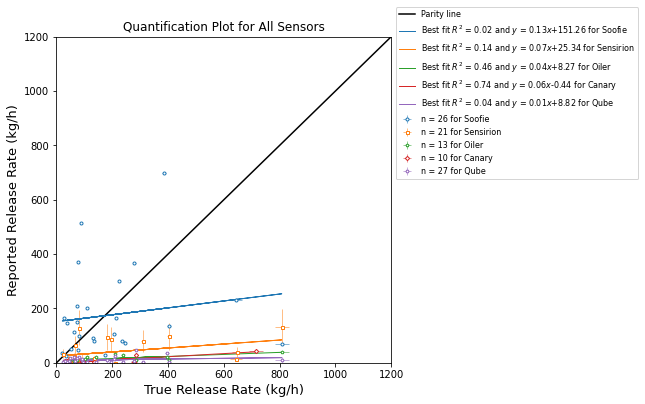

In [12]:
# make data
colors_dict = {}
markers_dict = {}
for i, k in enumerate(sensor_names):
    colors_dict[k] = colors[i]
    markers_dict[k] = markers[i]

fig, ax = plt.subplots(1, 1, figsize=[6,6])
ax = overall_plot(ax, mean_dfs, metrics_dfs, colors_dict, markers_dict, force_intercept_origin=0, error_value=None, plot_interval=['confidence'], legend_loc='lower right')
plt.title("Quantification Plot for All Sensors")
plt.legend(loc='lower right', bbox_to_anchor=(1.75, 0.55), fontsize=8)
if short_stack:
    pre_str = "ss_"
else:
    pre_str = ""
plt.savefig(PurePath(save_path, f"{pre_str}Linear_Regression_All_Sensors_with_errorbar.jpg"), dpi=300, bbox_inches='tight')